In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc
from ellipse import LsqEllipse
from math import comb
from matplotlib.patches import Ellipse
import scipy.optimize as sco
from scipy.optimize import fmin
from scipy.optimize import curve_fit
from scipy.optimize import root_scalar
import scipy
import json
import glob
import os
import allantools
from tqdm.notebook import trange, tqdm
import warnings
from clock_sim import *

 
warnings.filterwarnings("ignore")
rc('font',**{'family':'sans-serif','sans-serif':['Fira Sans'],'size':14,'style':'normal'})
rc('text', usetex=False)


BLUE = 'xkcd:pastel blue'
RED = 'xkcd:pastel red'
GREEN = 'xkcd:pastel green'
YELLOW ='xkcd:pastel yellow'
PURPLE = 'xkcd:pastel purple'
DBLUE = 'xkcd:light navy blue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE, RED, GREEN, YELLOW,PURPLE,DBLUE])

f0 = 429e12
h_const = 6.626e-34
G = 6.67e-11
M0 = 2e30
c = 3e8

def optimal_bandwidth(linewidth, laser_power, qe):
    return np.sqrt(qe*laser_power*linewidth/(h_const*f0))

def laser_phase_noise(linewidth, laser_power, qe):
    # bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    var_phi = h_const*f0*bandwidth/(qe*laser_power)+(linewidth/bandwidth)
    return np.sqrt(var_phi)

# --- 1/t model ---
def model_inv_t(t, A):
    """
    A / t + C
    """
    return A / t 


# --- 1/sqrt(t) model ---
def model_inv_sqrt_t(t, B):
    """
    B / sqrt(t) + C
    """
    return B / np.sqrt(t) 


# --- Quadrature sum: sqrt[(A/t)^2 + (B/sqrt(t))^2] + C ---
def model_quadrature(t, A, B):
    """
    sqrt( (A/t)^2 + (B/sqrt(t))^2 ) + C
    """
    return np.sqrt((A/t)**2 + (B/np.sqrt(t))**2) 


In [28]:
##FFD Analysis Functions




def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )
def likelihood(X,Y,P1,P2,n):
    N1 = X*n
    l1 = gaussian(N1,P1*n,np.sqrt(n*P1*(1-P1)))
    N2 = Y*n
    l2 = gaussian(N2,P2*n,np.sqrt(n*P2*(1-P2)))
    return l1*l2
        

def single_point_estimator(P1,P2,N,T,offset = np.pi/10):
    
    sub_ellipse_P1 = [np.squeeze(np.array(P1))]
    sub_ellipse_P2 = [np.squeeze(np.array(P2))]
    data = np.array(list(zip(sub_ellipse_P1, sub_ellipse_P2)))
    opt = MLE_optimized_err(data,N,N,offset,cov = False)
    return opt

def make_ellipse(phi,C1,xc,yc):
    phase_com = np.linspace(0,2*np.pi,200)
    P1 = 1/2*(1+np.cos(phase_com))
    P2 = 1/2*(1+np.cos(phase_com+phi))   
    return P1,P2

def likelihood_sum(phi, C1, C2, X, Y, xc, yc, n1, n2, phase_jitter_std = 0 ):
    phase_com = np.linspace(0, 2 * np.pi, 200000)

    # Effective contrasts from jitter
    C1_eff = np.abs(C1) * np.exp(-0.5 * phase_jitter_std**2)
    C2_eff = np.abs(C2) * np.exp(-0.5 * phase_jitter_std**2)

    # Raw P1, P2
    P1 = 0.5 * (1 + C1_eff * np.cos(phase_com))
    P2 = 0.5 * (1 + C2_eff * np.cos(phase_com + phi))

    # Clip to avoid exact 0 or 1
    eps = 1e-10
    P1 = np.clip(P1, eps, 1 - eps)
    P2 = np.clip(P2, eps, 1 - eps)

    # Repeat shapes
    X = np.repeat(X[:, None], len(phase_com), axis=1)
    Y = np.repeat(Y[:, None], len(phase_com), axis=1)
    P1 = np.repeat(P1[None, :], X.shape[0], axis=0)
    P2 = np.repeat(P2[None, :], Y.shape[0], axis=0)

    # QPN variance (in counts)
    sigma1_qpn = np.sqrt(n1 * P1 * (1 - P1))
    sigma2_qpn = np.sqrt(n2 * P2 * (1 - P2))


    # Total sigma (counts)
    sigma1 = np.sqrt(sigma1_qpn**2)
    sigma2 = np.sqrt(sigma2_qpn**2)

    sigma1 = np.where(sigma1 == 0, 1e-12, sigma1)
    sigma2 = np.where(sigma2 == 0, 1e-12, sigma2)

    # Gaussian likelihoods
    likes1 = gaussian(X * n1, P1 * n1, sigma1)
    likes2 = gaussian(Y * n2, P2 * n2, sigma2)
    likes = likes1 * likes2

    # Log likelihood
    loglikes = np.log(np.sum(likes, axis=1) + 1e-300)
    total_likelihood = np.sum(loglikes)
    return total_likelihood


def inverse(x, c):
    return x**(-.5) * c
    


def MLE_optimized_err(data, n1, n2, offset, pll_noise = 0 , g=False, guess=None, cov=False):
    import numpy as np
    import scipy.optimize as sco

    P1 = data[:, 0]
    P2 = data[:, 1]

    # Objective function: negative log-likelihood
    def objective(args):
        [p1] = args
        return -likelihood_sum(p1, 1, 1, np.array(P1), np.array(P2), 0.5, 0.5, n1, n2, phase_jitter_std = pll_noise)

    # Initial guess
    if not g or guess is None:
        guess1 = np.array([offset])
    else:
        guess1 = guess + 1e-4  # Replace epsilon with 1e-4 if not defined

    # Optimization
    opt = sco.minimize(
        objective,
        guess1,
        method='Nelder-Mead',
        options={'disp': False, 'xatol': 1e-9}
    )

    # Wrap and clean phase estimate
    phi_MLE = np.abs(opt.x[0])
    if phi_MLE > np.pi:
        phi_MLE = 2 * np.pi - phi_MLE

    # Compute standard error (if requested)
    if cov:
        h = 1e-5
        try:
            f_plus  = objective([phi_MLE + h])
            f_minus = objective([phi_MLE - h])
            f0      = objective([phi_MLE])
            second_deriv = (f_plus - 2 * f0 + f_minus) / (h ** 2)

            if second_deriv <= 0 or np.isnan(second_deriv):
                phase_jitter_std = np.nan
                print("⚠️ Warning: curvature non-positive or NaN — error estimate invalid.")
            else:
                phase_jitter_std = np.sqrt(1 / second_deriv)
        except:
            phase_jitter_std = np.nan
            print("⚠️ Error computing second derivative — returning NaN for uncertainty.")

        return phi_MLE, phase_jitter_std

    return np.array([phi_MLE])


def QPN_sim(p,n,C=1):
    return np.random.binomial(n,p)/n



def clock_average(signals,Ts,N = 1e7,offset = np.pi/10):
    C = 1
    P1 = []
    P2 = []
    pll_noise = laser_phase_noise(0.001,1e-10,1)
    phi_start = np.random.normal(0,pll_noise)
    for signal,T in tqdm(zip(signals,Ts), leave = False):
        phase_com =2*np.pi*np.random.rand(1)
        p1 = 1/2*(1+C*np.cos(phase_com))
        p1 = QPN_sim(p1,N,C)
        P1.append(p1)
        ffd = signal
        phi_end = np.random.normal(0,pll_noise)
        p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_end-phi_start))
        phi_start = phi_end
        p2 = QPN_sim(p2,N,C)
        P2.append(p2)
    P1 = np.squeeze(P1)
    P2 = np.squeeze(P2)
    
    data = np.array(list(zip(P1,P2)))
    opt = MLE_optimized_err(data,N,N,offset,cov = True)
    phi_measured = opt[0]
    phi_err = opt[1]
    return np.array(phi_measured)-offset,np.array(phi_err)


def clock_average_single_point(signals,Ts,N = 1e7,offset = np.pi/10):
    C = 1
    P1 = []
    P2 = []
    ffds = []
    pll_noise = laser_phase_noise(0.01,1e-8,1)
    phi_start = np.random.normal(0,pll_noise)
    for signal,T in tqdm(zip(signals,Ts), leave = False):
        phase_com =2*np.pi*np.random.rand(1)
        p1 = 1/2*(1+C*np.cos(phase_com))
        p1 = QPN_sim(p1,N,C)
        ffd = signal
        phi_end = np.random.normal(0,pll_noise)
        p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_end-phi_start))
        phi_start = phi_end
        p2 = QPN_sim(p2,N,C)
        opt = single_point_estimator(p1,p2,N,T,offset)
        ffds.append((opt[0]-offset)/(T*f0*2*np.pi))

    total_noise_per_cycle = np.std(ffds)
    laser_noise_per_cycle = pll_noise/(np.mean(Ts)*f0*2*np.pi)
    QPN_per_cycle = np.sqrt(total_noise_per_cycle**2-2*laser_noise_per_cycle**2)
    QPN_mean_error = QPN_per_cycle/np.sqrt(len(ffds))
    laser_noise_mean_error = laser_noise_per_cycle/len(ffds)
    
    ffd_mean_err = np.sqrt(QPN_mean_error**2+2*laser_noise_mean_error**2)
    
    
    return np.mean(ffds), ffd_mean_err

def adevffd(frac_freq_diff,t_ramsey,t_dead,N,C):
    t= np.linspace(1,150)
    r = 1/(t_ramsey+t_dead)
    t= np.linspace(1,len(frac_freq_diff)/r)
    #(t2, ad, ade, adn) = allantools.oadev(frac_freq_diff/f0, rate=r, data_type="freq", taus=t)
    (t2, ad, ade, adn) = allantools.oadev(frac_freq_diff, rate=r, data_type="freq")
    plt.plot(t2,ad)
    plt.xscale('log')
    plt.yscale('log')
    return (t2,ad,ade)

def jackknife_ffd(data,t_ramsey,t_dead,n1,n2,guess = None, g = False,phases = False):
    phi_i = []
    C_i = []
    guesses =[]
    for i in (tqdm(range(len(data)))):
        jk_data = np.delete(data,i,axis = 0)        
        opt_jk = MLE_optimized_err(jk_data,N,N,offset,cov = True)
        phi_D = opt_jk[0]
        phi_i.append(phi_D)
        
    guesses = np.transpose(np.array(guesses))
    
    phi_i = np.array(phi_i)
    shots = len(data)
    phi_jk_mean = np.mean(phi_i)*np.ones(shots)
    phi_jk_i = (phi_jk_mean*shots)-(phi_i*(shots-1))
    frac_freq_diff = np.array(phi_jk_i/t_ramsey/(2*np.pi))/f0
    
    if phases==True:
        if g:
            return [frac_freq_diff,phi_i,C_i,guess1]
        else:
            return [frac_freq_diff,phi_i,C_i]
    
    return frac_freq_diff


def jackknife_phi(data,n1,n2,offset):
    phi_i = []
    for i in (range(len(data))):
        jk_data = np.delete(data,i,axis = 0)        
        opt_jk= MLE_optimized(jk_data,n1,n2,offset)
        phi_i.append(opt_jk)

    
    phi_i = np.array(phi_i)
    return np.std(phi_i)

def QPN_scale(tau,N,C,t_ramsey,t_dead):
    return np.sqrt(2)/(2*np.pi*f0*C*t_ramsey)*(np.sqrt((t_ramsey+t_dead)/(N*(tau))))

def error_correction(C,phi):
    N =100 
    theta = np.linspace(0+10e-2,2*np.pi+10e-2,N)
    x = C/2*np.cos(theta)
    y = C/2*np.cos(theta+phi)
    var_x = (1/2-x)*(1/2+x)
    var_y = (1/2-y)*(1/2+y)
    integral = np.sum(1/(var_x/np.sin(theta)**2+var_x/np.sin(theta+phi)**2))/100    
    return 2/integral

In [3]:
laser_phase_noise(0.01,1e-9,1)

np.float64(0.0018362938460050326)

In [4]:
# N = 1e7
# n_meas = 600
# T = 100
# C = 1
# P1 = []
# P2 = []
# offset = np.pi/10
# pll_noise = laser_phase_noise(0.001,1e-10,1)
# phi_start = np.random.normal(0,pll_noise)
# for i in tqdm(range((n_meas)), leave = False):
#     phase_com =2*np.pi*np.random.rand(1)
#     p1 = 1/2*(1+C*np.cos(phase_com))
#     p1 = QPN_sim(p1,N,C)
#     P1.append(p1)
#     ffd = 0
#     phi_end = np.random.normal(0,pll_noise)
#     p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_end-phi_start))
#     phi_start = phi_end
#     p2 = QPN_sim(p2,N,C)
#     P2.append(p2)
# P1 = np.squeeze(P1)
# P2 = np.squeeze(P2)

# data = np.array(list(zip(P1,P2)))
# opt = MLE_optimized_err(data,N,N,offset,cov = True)
# frac_freq_diff_qpn_ln = jackknife_ffd(data,T,0,N,N)


# P1 = []
# P2 = []

# pll_noise = laser_phase_noise(0.001,1e-10,1)
# phi_start = 0
# for i in tqdm(range((n_meas)), leave = False):
#     phase_com =2*np.pi*np.random.rand(1)
#     p1 = 1/2*(1+C*np.cos(phase_com))
#     p1 = QPN_sim(p1,N,C)
#     P1.append(p1)
#     ffd = 0
#     phi_end = 0
#     p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_end-phi_start))
#     phi_start = 0
#     p2 = QPN_sim(p2,N,C)
#     P2.append(p2)
# P1 = np.squeeze(P1)
# P2 = np.squeeze(P2)

# data = np.array(list(zip(P1,P2)))
# opt = MLE_optimized_err(data,N,N,offset,cov = True)
# frac_freq_diff_qpn = jackknife_ffd(data,T,0,N,N)

# P1 = []
# P2 = []

# phi_start = np.random.normal(0,pll_noise)
# for i in tqdm(range((n_meas)), leave = False):
#     phase_com =2*np.pi*np.random.rand(1)
#     p1 = 1/2*(1+C*np.cos(phase_com))
#     P1.append(p1)
#     ffd = 0
#     phi_end = np.random.normal(0,pll_noise)
#     p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_end-phi_start))
#     phi_start = phi_end
#     P2.append(p2)
# P1 = np.squeeze(P1)
# P2 = np.squeeze(P2)

# data = np.array(list(zip(P1,P2)))
# opt = MLE_optimized_err(data,N,N,offset,cov = True)
# frac_freq_diff_ln = jackknife_ffd(data,T,0,N,N)


In [38]:
data_short = np.loadtxt('noise_analysis/ffds.txt')
# data_long = np.loadtxt('noise_analysis/ffds_longer.txt')

ValueError: too many values to unpack (expected 2)

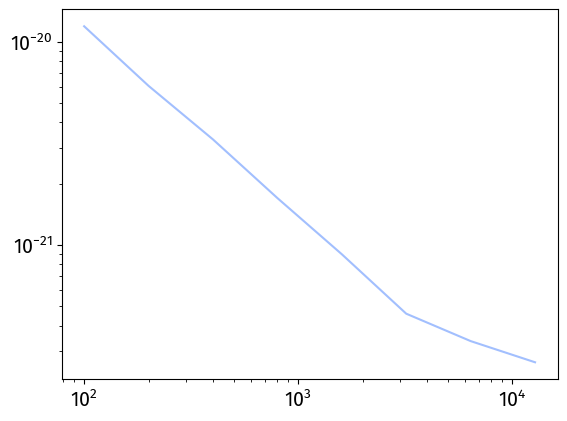

In [41]:
frac_freq_diff_qpn,frac_freq_diff_qpn_ln,frac_freq_diff_ln = data_short
T = 100
N = 1e7
t, ad1 = adevffd(frac_freq_diff_qpn_ln,T,0,N,1)
t, ad2 = adevffd(frac_freq_diff_qpn,T,0,N,1)
t, ad3 = adevffd(frac_freq_diff_ln,T,0,N,1)


frac_freq_diff_qpn,frac_freq_diff_qpn_ln,frac_freq_diff_ln = data_long

t2, ad1l = adevffd(frac_freq_diff_qpn_ln,T,0,N,1)
t2, ad2l = adevffd(frac_freq_diff_qpn,T,0,N,1)
t2, ad3l = adevffd(frac_freq_diff_ln,T,0,N,1)

In [7]:
plt.plot(t,ad1,t2,ad1l)
plt.xscale('log')
plt.yscale('log')

NameError: name 't' is not defined

In [8]:
plt.plot(t,ad1,'r.',t2,ad1l,'r.',alpha = 0.3)
plt.plot(t,ad2,'b.',t2,ad2l,'b.',alpha = 0.3)
plt.plot(t,ad3,'g.',t2,ad3l,'g.',alpha = 0.3)
plt.xscale('log')
plt.yscale('log')


from scipy.optimize import curve_fit

t_all = np.concatenate((t, t2))

ad_tot = np.concatenate((ad1, ad1l))
ad_qpn = np.concatenate((ad2, ad2l))
ad_ln = np.concatenate((ad3, ad3l))

popt, pcov = curve_fit(model_inv_t, t_all, ad_ln, p0=[ad_ln[1]*t_all[1]])
popt2, pcov2 = curve_fit(model_inv_sqrt_t, t_all, ad_qpn, p0=[ad_qpn[1]*np.sqrt(t_all[1])])
popt3, pcov3 = curve_fit(model_quadrature, t_all, ad_tot, p0=[ad_ln[1]*t_all[1],ad_qpn[1]*np.sqrt(t_all[1])])

ts = np.logspace(2,4.5,10000)
plt.plot(ts,model_inv_sqrt_t(ts,*popt2),'b')
plt.plot(ts,model_inv_t(ts,*popt),'g')
plt.plot(ts,model_quadrature(ts,popt,popt2),'r')
plt.plot(ts,model_quadrature(ts,*popt3),'r--')



NameError: name 't' is not defined

In [9]:

popt*f0*np.pi*np.sqrt(2)


NameError: name 'popt' is not defined

In [10]:
plt.plot(t2/3600,ad1,t2/3600,ad2,t2/3600,ad3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('')

NameError: name 't2' is not defined

In [19]:
C = 1
P1 = []
P2 = []
N = 1e7
cycles = 1000
ffds_tot_noise = []
offset = np.pi/10
pll_noise = laser_phase_noise(0.01,1e-9,1)/np.sqrt(2)
phi_start = np.random.normal(0,pll_noise)
for i in tqdm(range(cycles)):
    phase_com =2*np.pi*np.random.rand(1)
    p1 = 1/2*(1+C*np.cos(phase_com))
    p1 = QPN_sim(p1,N,C)
    ffd = 0
    phi_end = np.random.normal(0,pll_noise)
    p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_end-phi_start))
    phi_start = phi_end
    p2 = QPN_sim(p2,N,C)
    opt = single_point_estimator(p1,p2,N,T,offset)
    ffds_tot_noise.append((opt[0]-offset)/(T*f0*2*np.pi))


ffds_qpn = []
    
for i in tqdm(range(cycles)):
    phase_com =2*np.pi*np.random.rand(1)
    p1 = 1/2*(1+C*np.cos(phase_com))
    p1 = QPN_sim(p1,N,C)
    ffd = 0
    phi_end = np.random.normal(0,pll_noise)
    p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset))
    phi_start = phi_end
    p2 = QPN_sim(p2,N,C)
    opt = single_point_estimator(p1,p2,N,T,offset)
    ffds_qpn.append((opt[0]-offset)/(T*f0*2*np.pi))



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

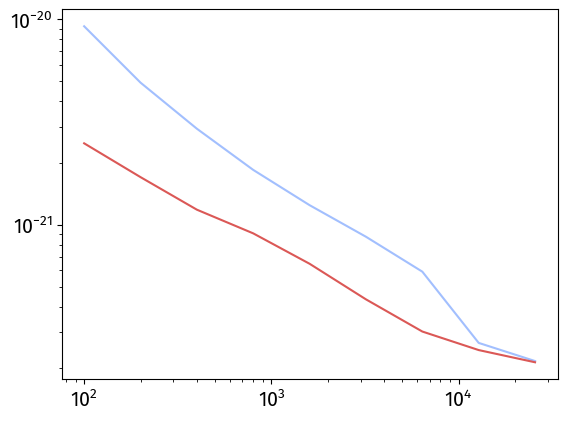

In [29]:
t_all, ad_tot, ade_tot = adevffd(ffds_tot_noise,T,0,N,1)
t_all, ad_qpn , ade_qpn= adevffd(ffds_qpn,T,0,N,1)

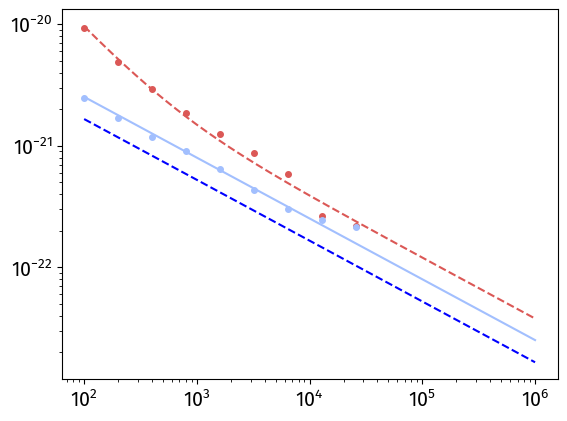

In [33]:
popt2, pcov2 = curve_fit(model_inv_sqrt_t, t_all, ad_qpn, sigma = ade_qpn, p0=[ad_qpn[1]*np.sqrt(t_all[1])])
popt3, pcov3 = curve_fit(model_quadrature, t_all, ad_tot, sigma = ade_tot, p0=[0.018/f0*np.pi,ad_qpn[1]*np.sqrt(t_all[1])])

ts = np.logspace(2,6,10000)
# plt.plot(ts,model_quadrature(ts,popt,popt2),color = RED)
plt.plot(ts,model_quadrature(ts,*popt3),color = RED, linestyle = '--')
plt.plot(ts,model_inv_sqrt_t(ts,*popt2),color = BLUE)

plt.plot(ts,QPN_scale(ts,N,1,T,0),'b--')
plt.errorbar(t_all,ad_tot,ade_tot,linestyle = 'None',markersize = 4, marker = 'o',color = RED)
plt.errorbar(t_all,ad_qpn,ade_qpn,linestyle = 'None',markersize = 4, marker = 'o',color = BLUE)
plt.xscale('log')
plt.yscale('log')


In [34]:
popt3*f0*np.pi*np.sqrt(2)

array([1.68345605e-03, 7.23719938e-05])

np.float64(0.0018308227213734108)

In [73]:
ffds_laser_noise = []
for i in tqdm(range(cycles)):
    phase_com =2*np.pi*np.random.rand(1)
    p1 = 1/2*(1+C*np.cos(phase_com))
   
    ffd = 0
    phi_end = np.random.normal(0,pll_noise)
    p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_end-phi_start))
    phi_start = phi_end
    opt = single_point_estimator(p1,p2,1e9,T,offset)
    ffds_laser_noise.append((opt[0]-offset)/(T*f0*2*np.pi))
    

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [75]:
popt3*f0*np.pi*np.sqrt(2)


array([2.21462046e-03, 7.03874583e-05])

In [ ]:
popt2

In [ ]:
popt3